# ERA5 GRIB to NETCDF Conversion
This notebook converts the ERA5 downloaded files (in GRIB format) to the appropriate netCDF format

In [1]:
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import sys
import os
import subprocess
import netCDF4 as nc
from loguru import logger
from tqdm import tqdm
import zipfile

## Pre-requisite Install: ecCodes
To install ecCodes,  run `conda install -c conda-forge eccodes` to install the binaries AND update the `requirements.in` file to build the python bindings 

For more detailed instructions on how to build from the source files, see [How to Install Eccodes on Ubuntu](https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a)

## Set up logging

In [2]:
LOG_PATH = Path("../../logs/")

# Configure logger
logger.remove()
logger.add(sys.stderr, format="{time} {level} {message}", level="INFO")

# Configure daily rotation for file logging
daily_sink_file_fmt = str(
    LOG_PATH / "ERA5_Surface_grib_to_nc_conversion_{time:YYYY-MM-DD}.log"
)
logger.add(
    daily_sink_file_fmt,
    rotation="00:00",
    format="{time} {level} {message}",
    level="TRACE",
)

2

In [3]:
# Helper function for writing subprocess outputs as trace logs
def log_subprocess_output_trace(pipe):
    """Logs output from subprocess pipe as trace messages
    In the current logging setup, 'trace' messages are written only
    to the log file (level="TRACE") and not sys.stderr / notebook output
    (level="INFO")
    """
    for line in iter(pipe.readline, b""):  # b'\n'-separated lines
        if line.isspace():
            continue

        logger.trace(f'{str(line,"utf-8").strip()}')

## Convert from GRIB to netcdf

In [4]:
# Helper function for testing if file can be successfully read as netcdf
def is_valid_nc(file):
    try:
        nc.Dataset(file)
        return True
    except Exception as e:
        logger.error(f"Exception raised: {e}")
        return False

In [5]:
# Function to extract files from zip archive
def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_to)

In [6]:
# Set the destination folder
RAW_DIR = Path("/mnt/c/Users/JCPeralta/Downloads")
INPUT_GRIB_FOLDER = Path("/mnt/c/Users/JCPeralta/Downloads/ERA5")
OUTPUT_NC_FOLDER = Path("/mnt/c/Users/JCPeralta/Downloads/ERA5_converted")
OUTPUT_NC_FOLDER.mkdir(exist_ok=True)

In [7]:
year = 2004
zip_file = RAW_DIR / f"ERA5_{year}.zip"
extract_zip(zip_file, INPUT_GRIB_FOLDER)

In [8]:
# Get list of downloaded surface files
era5_surface_grib_files = sorted(
    list(INPUT_GRIB_FOLDER.glob("**/*_surface_hourly.nc")), reverse=True
)
era5_surface_grib_files[:3], len(era5_surface_grib_files)

([PosixPath('/mnt/c/Users/JCPeralta/Downloads/ERA5/ERA5_PH_200612_surface_hourly.nc'),
  PosixPath('/mnt/c/Users/JCPeralta/Downloads/ERA5/ERA5_PH_200611_surface_hourly.nc'),
  PosixPath('/mnt/c/Users/JCPeralta/Downloads/ERA5/ERA5_PH_200610_surface_hourly.nc')],
 24)

In [9]:
for fn in os.listdir(INPUT_GRIB_FOLDER):
    os.remove(INPUT_GRIB_FOLDER / fn)

In [15]:
for year in [2019]:  # range(2018,2022):
    zip_file = RAW_DIR / f"ERA5_{year}.zip"
    extract_zip(zip_file, INPUT_GRIB_FOLDER)

    # Get list of downloaded surface files
    era5_surface_grib_files = sorted(
        list(INPUT_GRIB_FOLDER.glob("**/*_surface_hourly.nc")), reverse=True
    )
    era5_surface_grib_files[:3], len(era5_surface_grib_files)

    for f in tqdm(era5_surface_grib_files):
        try:
            # Check if input file is a valid nc file
            logger.info(f"Input file {f.name} is valid netcdf file: {is_valid_nc(f)}")
            if is_valid_nc(f):
                logger.info("Input file {f} is already valid! skipping request.")
                continue

            output_filename = f.name
            output_filepath = OUTPUT_NC_FOLDER / output_filename
            logger.info(
                f"Converting {f.name} from GRIB to NC and saving to {OUTPUT_NC_FOLDER}"
            )

            # Check if output_filename exists
            if (OUTPUT_NC_FOLDER / output_filename).is_file():
                logger.warning(f"{output_filepath} already exists! Skipping request.")
                continue

            # Specifying conversion command
            # -S param is an option set by ECMWF
            grib2netcf_command_str = (
                f"grib_to_netcdf -S param -o {str(output_filepath)} {str(f)}"
            )
            logger.info(f"Running command: {grib2netcf_command_str}")

            # Run conversion process and log messages to file
            conversion_process = subprocess.Popen(
                grib2netcf_command_str,
                shell=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            with conversion_process.stdout:
                log_subprocess_output_trace(conversion_process.stdout)
            exitcode = conversion_process.wait()  # waits for process to finish

            logger.info(
                f"Output file {output_filepath} is valid netcdf file: {is_valid_nc(output_filepath)}"
            )
            if is_valid_nc(output_filepath):
                logger.info(f"Successfuly converted {output_filepath}.")
            else:
                logger.warning(f"Conversion {output_filepath} not successful.")

        # Catch keyboard interrupts
        except KeyboardInterrupt:
            # Kill process if running
            try:
                conversion_process.kill()
            except Exception as e:
                logger.error(f"Exception raised: {e}")
            logger.error("Process interrupted using keyboard.")
            break

        # Catch other errors
        except Exception as e:
            logger.error(f"Exception raised: {e}")

    for fn in os.listdir(INPUT_GRIB_FOLDER):
        os.remove(INPUT_GRIB_FOLDER / fn)

  0%|          | 0/8 [00:00<?, ?it/s]2024-03-20T17:11:05.254076+0800 INFO Input file ERA5_PH_201912_surface_hourly.nc is valid netcdf file: False
2024-03-20T17:11:05.394386+0800 INFO Converting ERA5_PH_201912_surface_hourly.nc from GRIB to NC and saving to /mnt/c/Users/JCPeralta/Downloads/ERA5_converted
2024-03-20T17:11:05.395481+0800 WARNING /mnt/c/Users/JCPeralta/Downloads/ERA5_converted/ERA5_PH_201912_surface_hourly.nc already exists! Skipping request.
 12%|█▎        | 1/8 [00:00<00:02,  3.36it/s]2024-03-20T17:11:05.533177+0800 INFO Input file ERA5_PH_201911_surface_hourly.nc is valid netcdf file: False
2024-03-20T17:11:05.669778+0800 INFO Converting ERA5_PH_201911_surface_hourly.nc from GRIB to NC and saving to /mnt/c/Users/JCPeralta/Downloads/ERA5_converted
2024-03-20T17:11:05.670638+0800 WARNING /mnt/c/Users/JCPeralta/Downloads/ERA5_converted/ERA5_PH_201911_surface_hourly.nc already exists! Skipping request.
 25%|██▌       | 2/8 [00:00<00:01,  3.52it/s]2024-03-20T17:11:05.825552+

## Plot most recent output file

In [85]:
existing_output_files = list(OUTPUT_NC_FOLDER.glob("**/*"))
existing_output_files = [(f, f.lstat().st_mtime) for f in existing_output_files]
existing_output_files

[(PosixPath('../../data/converted_ERA5_Full_Download/ERA5_PH_202012_surface_hourly.nc'),
  1704363380.8720608),
 (PosixPath('../../data/converted_ERA5_Full_Download/ERA5_PH_202010_surface_hourly.nc'),
  1704363445.9720607),
 (PosixPath('../../data/converted_ERA5_Full_Download/ERA5_PH_202011_surface_hourly.nc'),
  1704363410.8820608)]

In [86]:
most_recent_file = max(existing_output_files, key=lambda x: x[1])[0]
print(most_recent_file)

../../data/converted_ERA5_Full_Download/ERA5_PH_202010_surface_hourly.nc


In [87]:
ds = xr.open_dataset(most_recent_file)
ds

<xarray.Dataset>
Dimensions:    (longitude: 43, latitude: 70, time: 744)
Coordinates:
  * longitude  (longitude) float32 116.5 116.8 117.0 117.2 ... 126.5 126.8 127.0
  * latitude   (latitude) float32 21.5 21.25 21.0 20.75 ... 5.0 4.75 4.5 4.25
  * time       (time) datetime64[ns] 2020-10-01 ... 2020-10-31T23:00:00
Data variables: (12/23)
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    cvh        (time, latitude, longitude) float32 ...
    cl         (time, latitude, longitude) float32 ...
    ...         ...
    slt        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    tvh        (time, latitude, longitude) float32 ...
    tvl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-04 10:17:20 GMT by grib_to_netcdf-2.33.0: grib_to_n...

In [88]:
# crs argument in ax.set_extent
lon_min = 116.5
lon_max = 127
lat_min = 4.25
lat_max = 21.5

VARIABLE_NAME = "t2m"

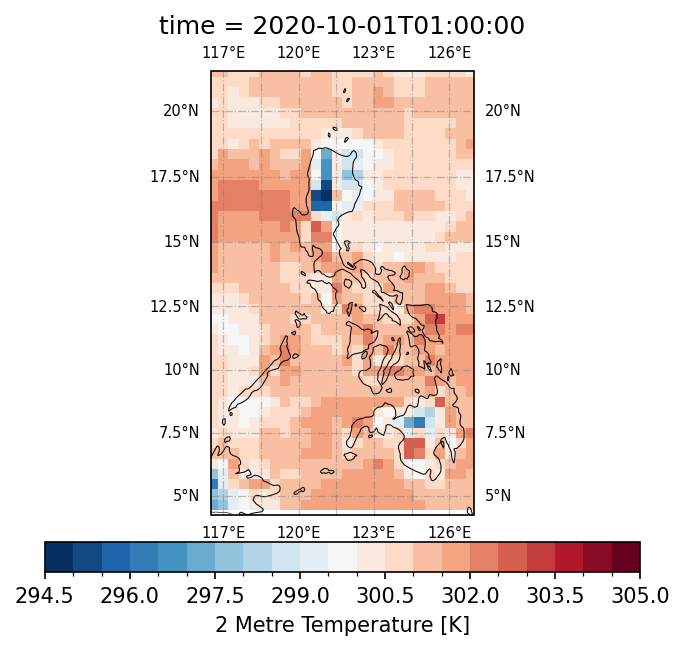

In [89]:
projection = ccrs.Mercator()
crs = ccrs.PlateCarree()
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(
    crs=crs, draw_labels=True, linewidth=0.6, color="gray", alpha=0.5, linestyle="-."
)
gl.xlabel_style = {"size": 7}
gl.ylabel_style = {"size": 7}

# To plot borders and coastlines, we can use cartopy feature
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

cbar_kwargs = {
    "orientation": "horizontal",
    "shrink": 0.8,
    "pad": 0.05,
    "label": "2 Metre Temperature [K]",
}
ds[VARIABLE_NAME].isel(time=1).plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    cbar_kwargs=cbar_kwargs,
    levels=21,
)

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)